# Lesson: K-Means Clustering

## Introduction

K-means clustering is an unsupervised machine learning model.

- **Supervised**: Linear, classifier, includes a dependent or target variable. **Labels** (synonym for target): known, ground-truth outcome the model is learning to predict.
- **Unsupervised**: Does not include a dependent or target variable. It ignores labels.

We can visualize groups in 2 or 3 dimensions, though in higher dimension features things get complicated.

<img src="../assets/k-means-2d.png" alt="K-means 2D" style="max-width: 50%;">

Our clusters range from 1 to K groups. Higher dimension features measure distances from data points: the closer, the better.

We have to have an intuition about K-means to maximize our chances for a good fit.

### Learning Outcomes

By the end of this lesson, you will be able to:

- Explain how the K-means clustering algorithm works.
- Prepare a dataset for K-means clustering.
- Describe a sensible method of choosing K if we don't have any pre-existing knowledge about the data.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

excluded_cols = ["year"]
str_cols = ["species", "island", "sex"]

df = pd.read_csv("../data/penguins_clean.csv")
df["sex"] = df["sex"].fillna("unknown")
df.dropna(inplace=True)
df.drop(columns=excluded_cols, inplace=True)

df = pd.get_dummies(df, columns=str_cols, drop_first=True, dtype=int)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 342 entries, 0 to 343
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bill_length_mm     342 non-null    float64
 1   bill_depth_mm      342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   species_Chinstrap  342 non-null    int64  
 5   species_Gentoo     342 non-null    int64  
 6   island_Dream       342 non-null    int64  
 7   island_Torgersen   342 non-null    int64  
 8   sex_male           342 non-null    int64  
 9   sex_unknown        342 non-null    int64  
dtypes: float64(4), int64(6)
memory usage: 29.4 KB


## How the Algorithm Works

Clustering does not have ground-truth labels. A common application of clustering is customer segmentation. Businesses group customers together based on their data: purchase history, revenue, demographics, etc. Customers are segmented. Maybe there's a "big spender" segment, a "college student" segment, and a "stingy" segment. It varies between customers. There is no perfect model.

K-means starts by choosing K random observations with **centroids** or center points of each cluster. It calculates the distance between the instance and the centroids, assigning it to the cluster whose distance is smallest.

Once the instance is assigned to a cluster, the algorithm recalculates the centroids of each cluster. It calculates the distances from each instance to each centroid and reassigns each instance to its nearest cluster. Since we recalculated the centroids, the distance calculations will change and cluster assignments may also change. The number of clusters, K, never changes. The algorithm fixes that from the beginning.

This process continues until no instances change clusters between iterations. At that point, the algorithm is said to have **converged**. The image below is a good depiction of this process, with K=3 clusters on a two-dimensional graph. While the algorithm is harder for humans to visualize in higher dimensions, the intuition remains the same.

![K-Means Convergence](../assets/k-means-convergence.gif)

As with every other ML algorithm, K-means has limitations.

- The algorithm is not deterministic. It starts by selecting K random instances as the initial centroids. While most modern implementations have smarter ways to choose centroids, random selections can converge strangely, which will affect our final clusters. We can tweak our `random_state` constants. Develop an intuition.

- Depending on the size of our dataset, this may add a significant amount of time to our training process.

- Using Euclidean distance or any other distance metric isn't the right approach to clustering. If we have a large number of features, we're also subject to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

- It requires the value of K to be chosen beforehand. If we're going into the clustering process with no knowledge of how many clusters we need or want, it can be difficult to choose an appropriate value of K. Different initial choices of K can produce dramatically different final results.

There are optimizations on K-means to improve its performance and mitigate some of the issues above. What we've presented is the simple, "standard" version to help us understand it conceptually. Some of the variations can be tuned as hyperparameters in many software implementations of K-means.

### Preprocessing and Tuning the Model

1\. Standardize. Since the K-means algorithm uses distance metrics, it's important to standardize our dataset so that every feature is on the same scale. This is a vital step. Don't forget.

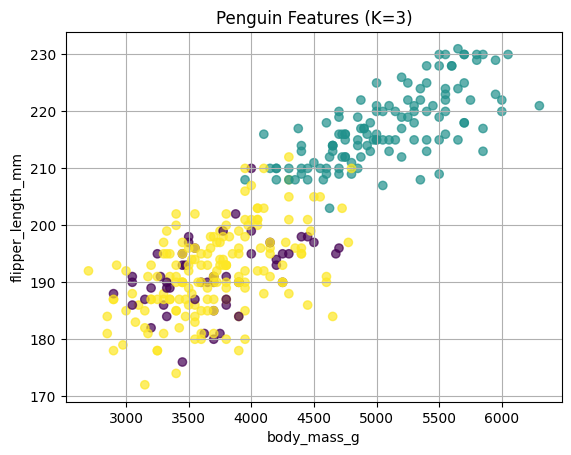

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = df.copy()
X_scaled = StandardScaler().fit_transform(X)

two_columns = ["body_mass_g", "flipper_length_mm"]

n_clusters = 3
model = KMeans(n_clusters=n_clusters, random_state=42)
clusters = model.fit_predict(X_scaled)

plt.scatter(X[two_columns[0]], X[two_columns[1]], c=clusters, alpha=0.7)
plt.title(f"Penguin Features (K={n_clusters})")
plt.xlabel(two_columns[0])
plt.ylabel(two_columns[1])
plt.grid(True)
plt.show()

2\. Choose the value of K. This can get tricky. If we have prior knowledge about how many clusters we want, we can use that information in our decision-making process. If we don't, we'll have to fit multiple models and compare them to each other. Play with a range from K=2 to K=10 clusters. We'll discuss this in more detail in the next section.

## Model Evaluation

Evaluation in an unsupervised setting is very different from evaluation in a supervised setting. We have no ground-truth answers. We can't say, "The model correctly labeled 98% of the ill subjects and 92% of the healthy subjects." Instead, we can only look at what the algorithm returned, determine whether we are satisfied with the results, and accept it or try something else. The only comparisons we make are between different models, not between a model's output and the ground-truth. (Incidentally, this also makes it more difficult to detect coding errors you may have made earlier in the process. If a classification model returns a Matthews correlation coefficient like -0.2, 99% of the time it indicates it wasn't configured properly. With an unsupervised problem like clustering, especially in higher dimensions that you can't directly visualize, it's much harder to detect this, so you have to be diligent)

Let's go back to the scenario where we chose a value of K. We constructed 9 different models, one for each of K=2 through K=10. Without prior knowledge, how do we choose one?

### Scree Plot

A common method is the scree plot, which plots the variance within each cluster on the vertical axis against the number of clusters (K) on the horizontal axis. This chart should be generally decreasing, as with more clusters, we'll have smaller clusters, which means less variance. The goal is to find a sharp "elbow" or a point at which the variance starts to change noticeably less with more clusters.

![K-Means Scree Plot](../assets/scree-plot-k-means.png)

The image above shows a scree plot, as well as one downside to this method. From the graph above, which value of K would you pick? 3 and 5 both seem like reasonable choices and you could probably make arguments for other values. There may be cases where there isn't a noticeable "elbow" at all. The scree plot method is useful, but it involves a large element of subjectivity.

More quantitative methods involve using measures known as **information criteria**, which are used to mitigate overfitting by penalizing overly complex models (in this case, higher values of K). The mathematics behind them are a bit too fancy for this course, but many software packages calculate them for you automatically.

If we're not satisfied with the results, try a different clustering algorithm. There are many clustering algorithms that work differently from K-means. One of those may be effective on our dataset. With unsupervised problems like clustering, it's more difficult to objectively evaluate model fit. That just comes with the territory.

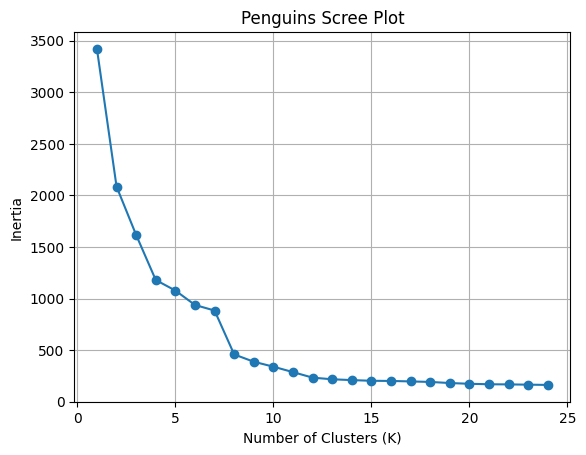

In [23]:
inertias = []

min = 1
max = 25

for k in range(min, max):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)

# Penguins Scree Plot
plt.plot(range(min, max), inertias, marker="o")
plt.title("Penguins Scree Plot")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

### Silhouette Analysis

Proposed by statistician Peter Rousseeuw in 1987. The higher the `silhouette_score`, the more effective the clusters. Though they may not be reliable. If we have irregular shapes or varying sizes, it won't go well.

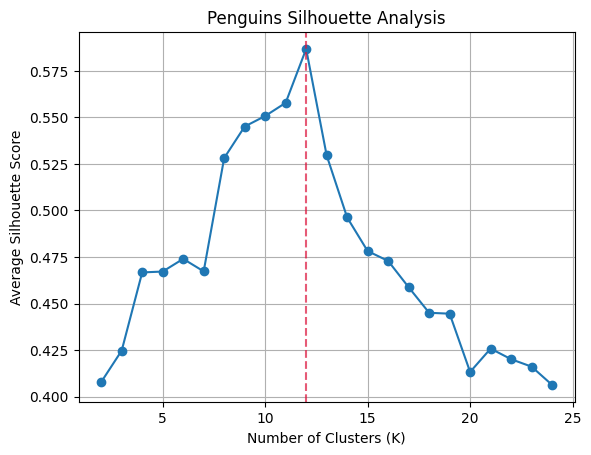

In [24]:
from sklearn.metrics import silhouette_score

silhouette = []

min = 2
max = 25
max_score = 0
max_k = 0

for k in range(min, max):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X_scaled)
    score = silhouette_score(X_scaled, model.labels_)
    if score > max_score:
        max_score = score
        max_k = k
    silhouette.append(score)


# Penguins Silhouette
plt.plot(range(min, max), silhouette, marker="o")
plt.axvline(x=max_k, color="crimson", linestyle="--", alpha=0.7)
plt.title("Penguins Silhouette Analysis")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)
plt.show()

Max silhouette score: 0.5867682722918596 at K=12


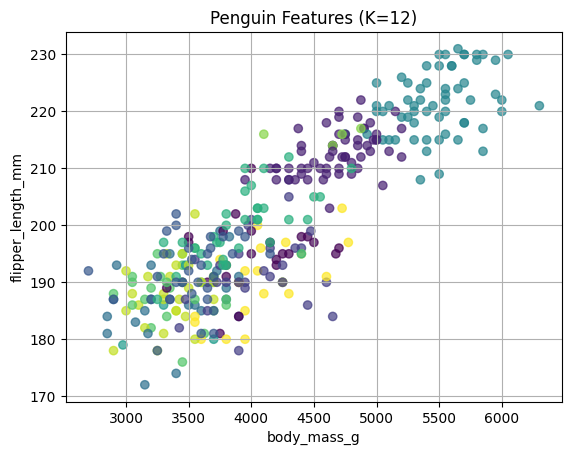

In [25]:
print(f"Max silhouette score: {max_score} at K={max_k}")
model = KMeans(n_clusters=max_k, random_state=42)
clusters = model.fit_predict(X_scaled)

plt.scatter(X[two_columns[0]], X[two_columns[1]], c=clusters, alpha=0.7)
plt.title(f"Penguin Features (K={max_k})")
plt.xlabel(two_columns[0])
plt.ylabel(two_columns[1])
plt.grid(True)
plt.show()